# Описание проекта

Постройте модель машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

В нашем распоряжении имеется 3 таблица, которые соответствуют информации о месторождениях в трёх регионах. Сохраним данные таблицы в три переменные *df1, df2, df3*.

In [5]:
import pandas as pd

df1 = pd.read_csv('../datasets/geo_data_0.csv')
df2 = pd.read_csv('../datasets/geo_data_1.csv')
df3 = pd.read_csv('../datasets/geo_data_2.csv')

# Для удобства сохраним наименование наших данных в лист. После, мы сможем автоматизировать некоторые операции. 

df = [df1,df2,df3]

[print(d.info()) for d in df]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

[None, None, None]

В таблицах находится информация по 100 000 месторождениям в каждом регионе. У нас имеется следующая информация:
- id — уникальный идентификатор месторождения;
- f0, f1, f2 — три признака точек;
- product — объём запасов в месторождении (тыс. баррелей). 

Как видно из информации по таблицам, у нас нет пропусков. Данный пункт пропустим при последующей обработке. 

### Поиск повторов

Начнём поиск по всем столбцам и по id. 

In [6]:
[print(f"Кол-во повторов = {d.duplicated().sum()}") for d in df]
[print(f"Кол-во повторов в ID = {d['id'].duplicated().sum()}") for d in df]

Кол-во повторов = 0
Кол-во повторов = 0
Кол-во повторов = 0
Кол-во повторов в ID = 10
Кол-во повторов в ID = 4
Кол-во повторов в ID = 4


[None, None, None]

Получается, что у нас есть повторы в столбце с ID. Их мало, поэтому мы можем удалить их. 


In [7]:
[d.drop_duplicates(subset = 'id', inplace = True) for d in df]

[None, None, None]

In [8]:
[print(f"Кол-во повторов = {d.duplicated().sum()}") for d in df]
[print(f"Кол-во повторов в ID = {d['id'].duplicated().sum()}") for d in df]

Кол-во повторов = 0
Кол-во повторов = 0
Кол-во повторов = 0
Кол-во повторов в ID = 0
Кол-во повторов в ID = 0
Кол-во повторов в ID = 0


[None, None, None]

Признак "Id" не предоставит пользы для будущей модели. Мы и так знаем, что каждая строка - отдельная скважина. Уберём идентификаторы. 

In [9]:
[d.drop('id',axis = 1, inplace = True) for d in df]

[None, None, None]

Посмотрим, как данные коррелируют между собой. Для этого построим *heatmap* для каждого региона.

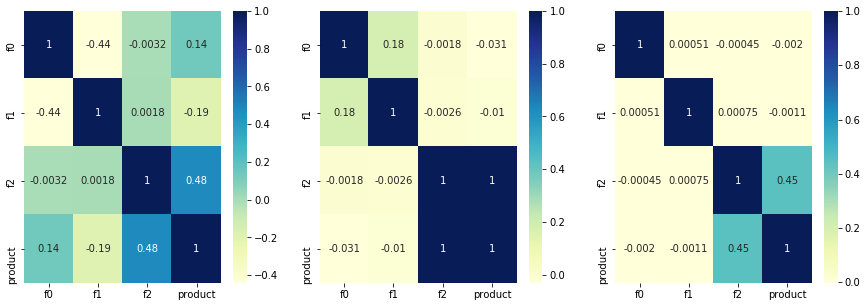

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

sns.heatmap(df1.corr(), annot=True, cmap="YlGnBu", ax = ax1)
sns.heatmap(df2.corr(), annot=True, cmap="YlGnBu", ax = ax2)
sns.heatmap(df3.corr(), annot=True, cmap="YlGnBu", ax = ax3)

plt.show()

Построим *scatterplot* распределение от признака *f2* и целевого значения *product*.

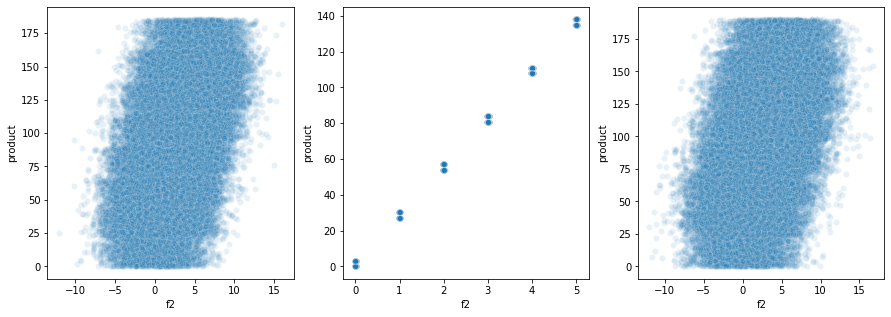

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

sns.scatterplot(data = df1, cmap="YlGnBu", ax = ax1, x = 'f2', y = 'product', alpha = .1)
sns.scatterplot(data = df2, cmap="YlGnBu", ax = ax2, x = 'f2', y = 'product', alpha = .1)
sns.scatterplot(data = df3, cmap="YlGnBu", ax = ax3, x = 'f2', y = 'product', alpha = .1)

plt.show()

Такая корреляция может сказать об утечки целевого признака. Посмотрим как повлияет данный признак на модель. 

### Краткие выводы

При анализе полученных данных нам удалось определить следующее:

- Перед нами три таблицы / региона, в которых находятся 100 000 тыс. записей о месторождениях нефти.
- В таблицах нет пропусков и повторов строк.
- При исследовании корреляции видно, что во всех регионах влияющим на запас нефти признаком является *f2*. Для второго региона коэффициент корреляции = 1. Это может говорить об утечке целевеого признака.

# 2. Обучение и проверка модели

Создадим функцию ```model_calc```, которая принимает на вход данные по региону, а на выходе мы получим:
- Предсказания (preds)
- Правильные ответы (y_test)
- Значение метрики *RMSE*
- Средний предсказанный запас сырья (avg)



Для модели используем линейную регрессию.

In [12]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


def model_calc(df):
    """
    df: данные по одному региону
    return:
        preds - предсказаня
        y_test - правильные ответы
        rmse - cреднеквадратическая ошибка модели 
    """
    # Отделяем признаки и таргет 
    y = df['product']
    X = df.drop(['product'], axis = 1)
    
    # Проводим разделение на обучающую и тестовую выборку и скалирование значений. 
    
    from sklearn.preprocessing import StandardScaler
    X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X),
                                                        y, 
                                                        test_size=.25,
                                                        random_state=42)
    line_reg = LinearRegression()
    line_reg.fit(X_train,y_train)
    
    preds = cross_val_predict(line_reg, X_test,y_test, cv = 5)
    
    mse = mean_squared_error(y_test, preds)
    
    rmse = np.sqrt(mse)
    
    avg = sum(preds) / len(preds)
    
    
    return preds,y_test,rmse, avg 


Проведём построение итоговой таблицы:
- Построение будет для 3х регионов, но для второго мы посчитаем ошибку с и без признака *f2*
- Отдель посчитаем средний объём нефти (в тыс. баррелей)

In [13]:
df1_res = model_calc(df1)
df2_without_f2 = model_calc(df2.drop('f2',axis=1))
df2_res = model_calc(df2)
df3_res = model_calc(df3)

df_calc = [df1_res, df2_res, df3_res]


result = pd.DataFrame(np.array([[df1_res[2], df1_res[3]],
                                [df2_without_f2[2],df2_without_f2[3]],
                                [df2_res[2],df2_res[3]],
                                [df3_res[2],df3_res[3]]]),
                      columns=['rmse','avg'], 
                      index = ['df1','df2-f2','df2','df3'])

result

,rmse,avg
df1,37.687617,92.391034
df2-f2,45.946624,68.586173
df2,0.892884,68.583610
df3,40.083848,95.251781


### Краткие выводы

Произвели расчёт метрик для наших регионов. Из полученных значений мы можем сделать следующиее выводы:

- По расчётным данным третий регион обладает в среднем большим запасом нефти
- При анализе данных была выявлена утечка целевого признака и его прямую зависимость от *f2* признака для второго региона. После обучения модели видно, что ошибка для второго региона с учетом признака *f2* минимальна. 

# 3. Подготовка к расчёту прибыли

Произведём подготовку по данному плану:
- Создание констант с ключевыми значениями для расчётов
- Минимальный средний объём сырья в месторождениях региона, достаточный для его разработки. 
- Функция для расчёта прибыли по набору отобранных месторождений и предсказаний модели. 

### Константы

Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
Один баррель сырья приносит 4500 рублей прибыли.

Сохраним эту информацию в соответствующие константы. 

In [14]:
# Бюджет на разработку региона
DEV_BUDGET = 10000000000
# Цена бурения одной скважины
PRICEBOR= 50000000
# Цена за 1 баррель нефти 
BBLPRICE = 4500

# кол-во точек, разработка которых помещается в бюджет
N = DEV_BUDGET / PRICEBOR

### Минимальный средний объём сырья

Минимальный объём сырья для получения прибыли с точки равен:

$$MINVAL = \frac{PRICEBOR}{BBLPRICE} = \frac{50000000}{4500} =~ 11111.1 $$

Запишем это в коде и сохраним минимальный объём в переменную *MINVAL*

In [15]:
MINVAL = PRICEBOR / BBLPRICE
MINVAL

11111.111111111111

Посмотрим, сколько точек несоответствует данному условию. 

In [16]:
for data in df_calc:
    print((data[0]*1000 <= MINVAL).sum())

4
4147
0


В первом и втором регионе имеются точки, объём добычи с которых не соответствует минимальному. Избавимся от таких точек.

In [17]:
df1_predict = pd.Series([d for d in df1_res[0] if d*1000 >=MINVAL]).sort_values(ascending = False)
df2_predict = pd.Series([d for d in df2_res[0] if d*1000 >=MINVAL]).sort_values(ascending = False)
df3_predict = pd.Series([d for d in df3_res[0] if d*1000 >=MINVAL]).sort_values(ascending = False)


df1_predict.head()

19473    186.199840
12146    184.916280
6527     177.007283
2965     175.413189
5280     173.558727
dtype: float64

#### Краткий вывод


После расчёта минимального объёма мы выяснили, что во втором регионе имеется множество точек с малым объёмом нефти. Разработка таких точек не покроет затраты на её разработку.

В связи с этим, мы отфильтровали наши данные и провели сортировку по убыванию. В дальнейшей обработке нам важно использовать самые прибыльные скважины. 

### Функция для расчёта прибыли по набору отобранных месторождений и предсказаний модели. 

In [18]:
def profit_calc(df):
    """
    df - объём нефти по скважинам 
    return: возвращаем рублевый эквивалент (с учетом цены на бурение скважины)
    """
    return df * 1000 * 4500 - PRICEBOR


# 4. Расчёт прибыли и рисков 

- Bootstrap (1000 выборок) для получения распределения прибыли. 
- Средняя прибыль, 95% доверительный интервал, риск убытков.
- Выводы: Лучший регион.

Для начала определимся, сколько sample-ов будем брать из наших данных. Нам известно, что бюджета хватит для разработки 200 месторождений. (DEV_BUDGET / PRICEBOR).

Используем эту цифру в дальнейших расчётах. 



Создаем функцию ```bootstrap``` для применения к 3 регионам. 

Данная функция будет выполнять следующее:

- Применяет технику bootstrap для 1000 примеров по 200 скважин в каждом. 
- Переведём тысячи баррелей в рубли с учетом затрат на бурение (50 млн)
- Возвращает по нашим выборка следующие параметры:
    - Распределение прибыли
    - Средняя прибыль
    - 95% доверительный интервал

In [19]:
# Bootstrap 
from scipy import stats as st
state = np.random.RandomState(12345) 

def bootstrap(data, samples = 1000, n = 200):
    result = []
    
    for i in range(samples): # берём 1000 семплов
        
        d = profit_calc(data) # переводим баррели в рубли с точки
        subsample = d.sample(n, replace = True, random_state = state) # берём подсемпл из n точек (рубли)
        result.append(subsample.mean()) # добавляем среднее по 500 точкам
    
    
    result = pd.Series(result)   
    confidence_interval = st.t.interval(alpha = .95,
                                        df = result.shape[0]-1,
                                        loc = result.mean(), 
                                        scale = result.sem())   
    mean_profit = result.mean()
    
    return result, mean_profit, confidence_interval

df1_info = bootstrap(df1_predict)
df2_info = bootstrap(df2_predict)
df3_info = bootstrap(df3_predict)

#### Распределение 

Построим распределение прибыли. (в миллионах рублей)

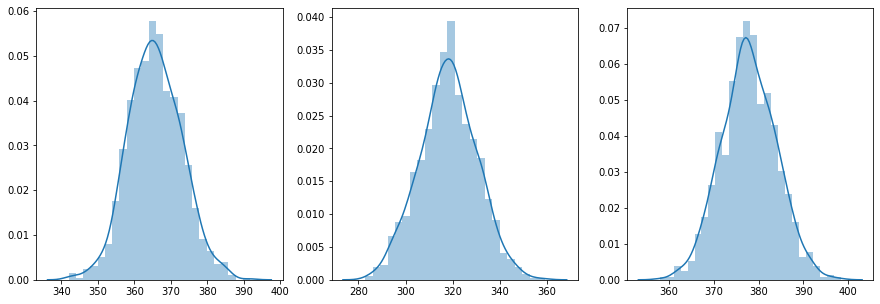

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

sns.distplot(df1_info[0]/1000000, ax = ax1)
sns.distplot(df2_info[0]/1000000, ax = ax2)
sns.distplot(df3_info[0]/1000000, ax = ax3)

plt.show()

По распределениям видно, что концетрация самых прибыльных точек выше в 3 регионе. 

Посмотрим на среднюю прибыль и доверительные интервалы:

In [21]:
pd.DataFrame(index = [1,2,3],
            columns = ['mean_profit','95% lower','95% upper'],
            data = [[df1_info[1]/1000000,df1_info[2][0]/1000000,df1_info[2][1]/1000000],
                   [df2_info[1]/1000000,df2_info[2][0]/1000000,df2_info[2][1]/1000000],
                   [df3_info[1]/1000000,df3_info[2][0]/1000000,df3_info[2][1]/1000000]])

,mean_profit,95% lower,95% upper
1,365.745470,365.293868,366.197073
2,318.102980,317.352233,318.853727
3,377.835312,377.458785,378.211839


## Выводы


В процессе работы мы провели анализ трёх регионов для выбора месторождений для разработки. 

- По расчётным данным третий регион обладает в среднем большим запасом нефти
- При анализе данных была выявлена утечка целевого признака и его прямую зависимость от *f2* признака для второго региона. Было принято решение не учитывать данный признак при обработке, так как он мог повлиять на оценку ошибки. 

После расчёта минимального объёма мы выяснили, что во втором регионе имеется множество точек с малым объёмом нефти. Разработка таких точек не покроет затраты на её разработку.

В связи с этим, мы отфильтровали наши данные и провели сортировку по убыванию. В дальнейшей обработке нам было важно использовать самые прибыльные скважины. 

Была применения техника *bootstrap* для получения распределения прибыли. В процессе были посчитаны 95% процентные интервалы для всех регионов и средняя прибыль. 

Самым прибыльным является 3 регион. Рекомендуется производить его разработку. 